In [110]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit

In [128]:
#path = r"C:/Data/20220629/vacuum_-109C_setpoint_new/"
path = '/Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/'
SRS_gain = 100
peak_threshold = 700
breakdown = 27.4
pedestal = 275

file_list = natsort.realsorted(glob.glob(path + "mca*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 11 files


In [129]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [176]:
def fit_hist(bc, hh, spe_loc, fit_thresh, guess_sig = 0.1, numsig=4, max_peaks=6):
    
    out_vals = []
    numsig_orig = 1.*numsig
    sig = spe_loc*guess_sig
    
    updated = False
    for n in range(1,max_peaks):
        
        if( n*spe_loc + pedestal < fit_thresh):
            numsig = 2.0
            continue

        #numsig = 1.*numsig_orig
        fpts = (bc >= n*spe_loc - numsig*sig + pedestal) & (bc <= n*spe_loc + numsig*sig + pedestal) & (bc>fit_thresh)
        if(np.sum(fpts) == 0): 
            continue

        spars = [50, n*spe_loc+pedestal, sig]

        #if(True):
        #    mu = n*spe_loc + pedestal
        #    xx = np.linspace( mu - numsig*sig, mu + numsig*sig, 100 )
        #    plt.plot( xx, gauss_fun(xx, *spars), 'g' )

        try:
            bestp, covp = curve_fit(gauss_fun, bc[fpts], hh[fpts], p0=spars)
        except RuntimeError as r:
            out_vals.append([n, np.nan, np.nan, np.nan])
            xx = np.linspace( n*spe_loc - numsig*sig + pedestal, n*spe_loc + numsig*sig + pedestal, 100 )
            plt.plot( xx, gauss_fun(xx, *spars), 'b' )
            continue

        ## update range and refit
        if(not updated):
            spe_loc = (bestp[1] - pedestal)/n 
            sig = np.abs(bestp[2])
            updated = True
                
        #numsig = 3.*numsig_orig
        fpts = ( bc >= n*spe_loc - numsig*sig + pedestal) & (bc <= n*spe_loc + numsig*sig + pedestal) & (bc>fit_thresh)
        if(np.sum(fpts)< 10):
            out_vals.append([n, np.nan, np.nan, np.nan])
            continue
        try:
            bestp, covp = curve_fit(gauss_fun, bc[fpts], hh[fpts], p0=[1, n*spe_loc, sig])
        except RuntimeError as r:
            out_vals.append([n, np.nan, np.nan, np.nan])
            xx = np.linspace( n*spe_loc - numsig*sig + pedestal, n*spe_loc + numsig*sig + pedestal, 100 )
            plt.plot( xx, gauss_fun(xx, *spars), 'orange' )
            continue

        out_vals.append([n, bestp[1], np.sqrt(covp[1,1]), bestp[2]])
        
        xx = np.linspace( n*spe_loc - numsig*sig + pedestal, n*spe_loc + numsig*sig + pedestal, 100 )
        plt.plot( xx, gauss_fun(xx, *bestp), 'r' )

    return np.array(out_vals)

Working on file #0: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_31.38OV_0.h5
guess sig:  0.11021841527954415


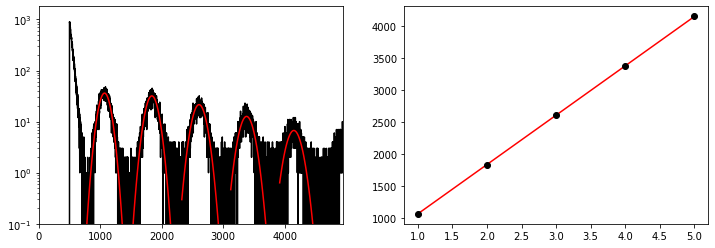

Working on file #1: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_31.18OV_0.h5
guess sig:  0.07187900579779348


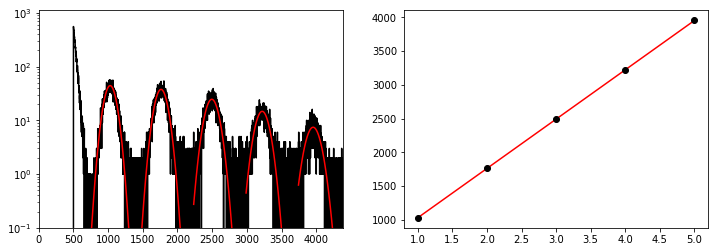

Working on file #2: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_30.98OV_0.h5
guess sig:  0.0787962715742731


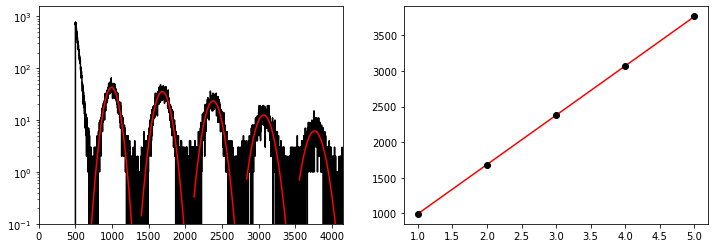

Working on file #3: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_30.78OV_0.h5
guess sig:  0.10257435869916945


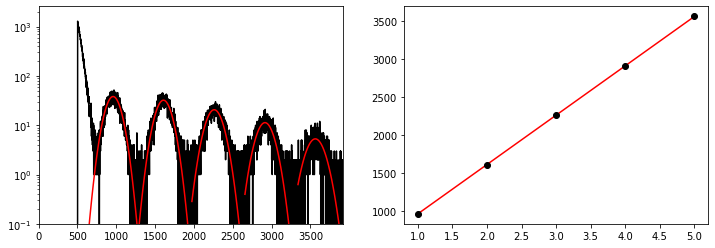

Working on file #4: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_30.58OV_0.h5
guess sig:  0.1367470570101572


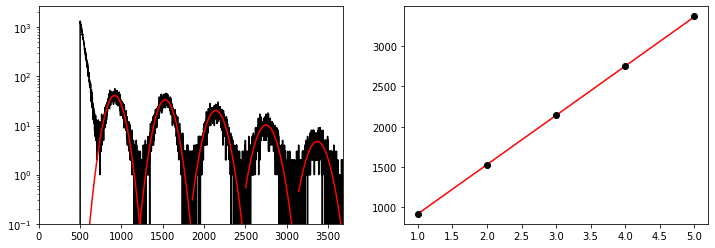

Working on file #5: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_30.38OV_0.h5
guess sig:  0.09191718570296378


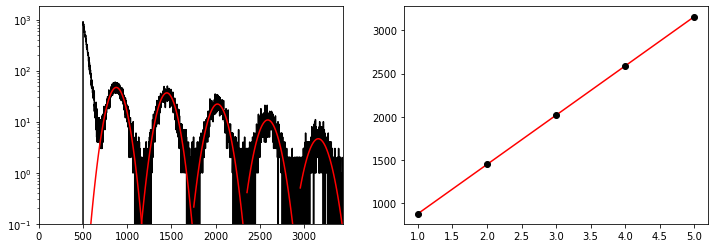

Working on file #6: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_30.18OV_0.h5
guess sig:  0.09314933856240123


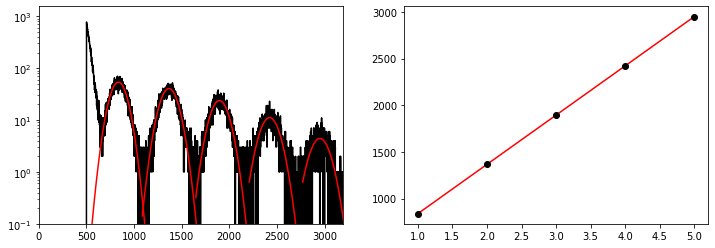

Working on file #7: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_29.98OV_0.h5
guess sig:  0.13147759961637043


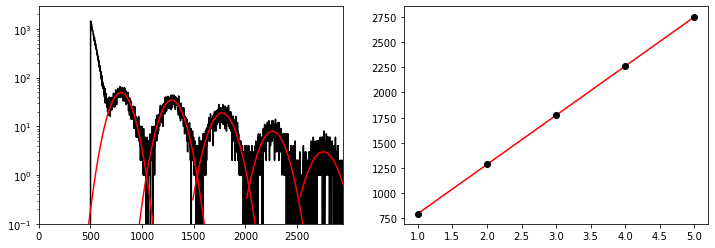

Working on file #8: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_29.78OV_0.h5
guess sig:  0.20885847996285445


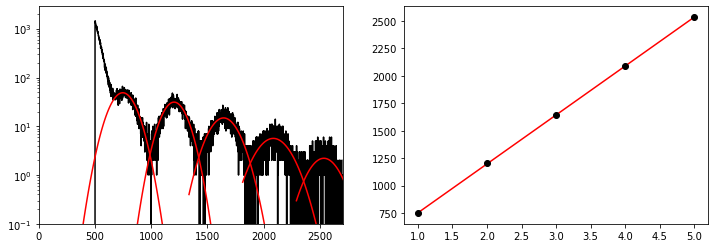

Working on file #9: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_29.58OV_0.h5
guess sig:  0.027447196352992868


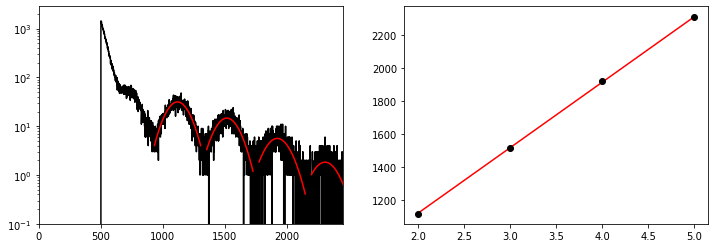

Working on file #10: /Users/dcmoore/data/20220629/vacuum_-109C_setpoint_new/mca_keith_29.38OV_0.h5
guess sig:  0.1960393576471865


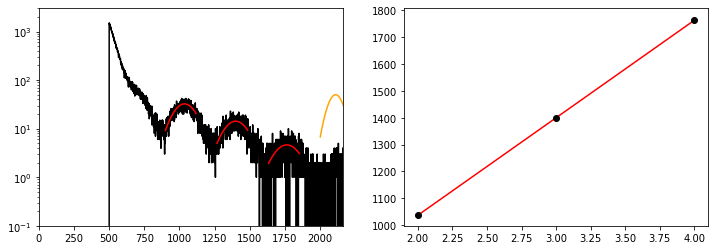

In [177]:
guess_1pe = 1100 * SRS_gain/100 - pedestal ## based on highest gain data
guess_sig = 0.1

gain_vs_volts = []
for i,file in enumerate(file_list): 
    print("Working on file #%d: %s"%(i,file))

    file_parts = file.split("_")
    file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.semilogy(bin_num, mca_hist, 'k')
    plt.ylim(0.1, np.max(mca_hist)*2)

    if( len(gain_vs_volts)> 0):
        guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    pe_locs = fit_hist(bin_num, mca_hist, guess_1pe, peak_threshold, guess_sig=guess_sig)
    plt.xlim(0, guess_1pe*6)


    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    fpts = ~np.isnan(pe_locs[:,1])
    if(np.sum(fpts) < 3):
        continue
    gain_bp, gain_bc = curve_fit( lin_fun, pe_locs[fpts, 0], pe_locs[fpts, 1] )

    guess_sig = 3*np.abs(np.median(pe_locs[fpts, 3]/pe_locs[fpts, 1]))
    print("guess sig: ", guess_sig)

    xx = pe_locs[fpts, 0]
    plt.plot( xx, lin_fun(xx, *gain_bp), 'r')

    gain_vs_volts.append( [file_volts, gain_bp[0], np.sqrt(gain_bc[0,0])] )

    plt.show()

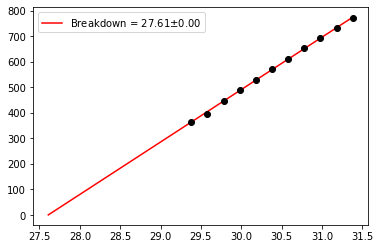

In [178]:
gain_vs_volts = np.array(gain_vs_volts[::-1])

max_pts = 100
bd_bp, bd_bc = curve_fit(lin_fun, gain_vs_volts[:max_pts, 0], gain_vs_volts[:max_pts, 1], sigma=gain_vs_volts[:max_pts, 2])

plt.figure()
plt.errorbar(gain_vs_volts[:,0], gain_vs_volts[:,1], yerr=gain_vs_volts[:,2], fmt='ko')
xx = np.linspace(bd_bp[1], np.max(gain_vs_volts[:,0]), 100)
plt.plot(xx, lin_fun(xx,*bd_bp), 'r', label="Breakdown = %.2f$\pm$%.2f"%(bd_bp[1], np.sqrt(bd_bc[1,1])))
plt.legend()
plt.show()